In [1]:
import ops
% matplotlib inline

In [2]:
dicts, tot_times = ops.parse_all_timeline_files('/Users/syz/Dropbox (ORNL)/Atom_AI/exascale_AI_project/resnet_50_heavy')

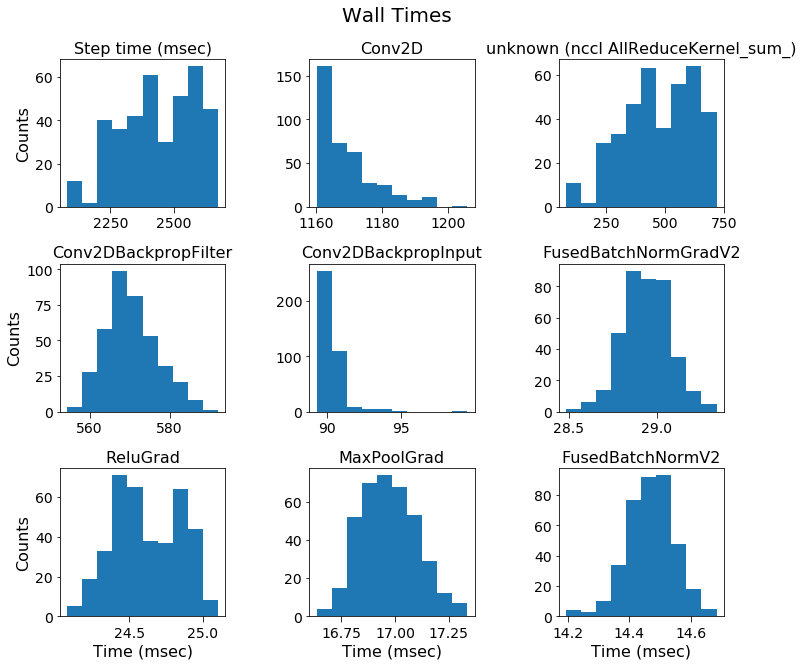

In [4]:
fig = ops.visualize_op_times(dicts, tot_times)

In [8]:
# Load timeline and get all ops information
dic = ops.json_to_ordered_dict('timeline.ctf.3.json')
all_ops = ops.get_all_ops(dic)
# Find Names of unique Ops
unique_op_names = ops.get_unique_ops_names(all_ops)
print(unique_op_names)

set([u'RealDiv', u'Const', u'Sub', u'ExpandDims', u'Reshape', u'Sum', u'Conv2DBackpropFilter', u'Relu', u'ShapeN', u'Conv2DBackpropInput', u'AssignAdd', u'Unstage', u'MaxPoolGrad', u'Split', u'Mul', u'Tile', u'_ParallelConcatUpdate', u'AvgPool', u'HorovodAllreduce', u'MEMCPYDtoH', u'unknown', u'Floor', u'Transpose', u'MatMul', u'FusedBatchNormGradV2', u'Neg', u'AddN', u'Squeeze', u'Identity', u'Stage', u'ConcatV2', u'ParseExample', u'RecordInput', u'FusedBatchNormV2', u'DecodeRaw', u'_Retval', u'Maximum', u'Cast', u'L2Loss', u'SquaredDifference', u'ApplyAdam', u'Sqrt', u'AvgPoolGrad', u'MEMCPYDtoD', u'BiasAddGrad', u'Assign', u'Mean', u'ReluGrad', u'_ParallelConcatStart', u'Square', u'Pow', u'VariableV2', u'MaxPool', u'Add', u'BiasAdd', u'AssignSub', u'NoOp', u'Select', u'MEMCPYHtoD', u'Conv2D'])


In [9]:
proc_dic, stream_all_pid = ops.get_stream_all(trace_dic=dic)
proc_dic

{u'/device:GPU:0/memcpy Compute': 11,
 u'/device:GPU:0/memcpy Tensors': 12,
 u'/device:GPU:0/stream:13 Compute': 7,
 u'/device:GPU:0/stream:13 Tensors': 8,
 u'/device:GPU:0/stream:14 Compute': 13,
 u'/device:GPU:0/stream:14 Tensors': 14,
 u'/device:GPU:0/stream:15 Compute': 15,
 u'/device:GPU:0/stream:15 Tensors': 16,
 u'/device:GPU:0/stream:26 Compute': 9,
 u'/device:GPU:0/stream:26 Tensors': 10,
 u'/device:GPU:0/stream:all Compute': 5,
 u'/device:GPU:0/stream:all Tensors': 6,
 u'/job:localhost/replica:0/task:0/device:CPU:0 Compute': 1,
 u'/job:localhost/replica:0/task:0/device:CPU:0 Tensors': 2,
 u'/job:localhost/replica:0/task:0/device:GPU:0 Compute': 3,
 u'/job:localhost/replica:0/task:0/device:GPU:0 Tensors': 4,
 u'Allocators': 0}

In [10]:
# Calculate wall duration of all ops
dur_dic_all, total_dur = ops.get_wall_duration(unique_op_names, all_ops, pid_list=[stream_all_pid])
ops.print_timeline_stats(dur_dic_all, total_dur)

Total Wall Duration (ms): 254.361

OPS with wall duration > 5 ms:
Conv2DBackpropFilter : 56.088 ms
Conv2DBackpropInput : 39.941 ms
unknown (nccl AllReduceKernel_sum_) : 36.463 ms
Conv2D : 31.708 ms
FusedBatchNormGradV2 : 21.278 ms
ReluGrad : 14.530 ms
FusedBatchNormV2 : 14.393 ms
Relu : 7.151 ms
Add : 6.801 ms
MaxPoolGrad : 6.675 ms
AddN : 5.869 ms
